In [1]:
import geopandas as gpd
import pandas as pd
import folium 
import matplotlib.pyplot as plt
import mapclassify



manhattan_parks_gdf = gpd.read_file("manhattan_park_details.geojson")
manhattan_taxi_zones_gdf = gpd.read_file("manhattan_taxi_zones.geojson")




see all columns

In [2]:
pd.set_option('display.max_columns', None)
#display all columns not truncated

we make sure the CRS of both geodataframes are the same

In [3]:
print(manhattan_parks_gdf.crs)
print(manhattan_taxi_zones_gdf.crs)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [4]:
manhattan_taxi_zones_gdf.head()

,shape_area,objectid,shape_leng,location_id,zone,borough,geometry
0,0.000111871946192,4,0.0435665270921,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."
1,0.0000607235737749,24,0.0469999619287,24,Bloomingdale,Manhattan,"MULTIPOLYGON (((-73.95954 40.79872, -73.96004 ..."
2,0.0000415116236727,12,0.0366613013579,12,Battery Park,Manhattan,"MULTIPOLYGON (((-74.01566 40.70483, -74.01540 ..."
3,0.000149358592917,13,0.0502813228631,13,Battery Park City,Manhattan,"MULTIPOLYGON (((-74.01244 40.71906, -74.01282 ..."
4,0.000143093037737,41,0.052793109453,41,Central Harlem,Manhattan,"MULTIPOLYGON (((-73.94774 40.80960, -73.94506 ..."


In [5]:
manhattan_parks_gdf.head()

,id,name,website,area,geometry
0,relation/1751075,John Jay Park,None,0.000001,"POLYGON ((-73.94901 40.76981, -73.94944 40.770..."
1,relation/2389631,Governors Island,https://www.nps.gov/gois/index.htm,0.000074,"POLYGON ((-74.01540 40.69306, -74.01556 40.693..."
2,relation/3690816,Highbridge Park,https://www.nycgovparks.org/parks/highbridge-p...,0.000056,"MULTIPOLYGON (((-73.93110 40.84702, -73.93112 ..."
3,relation/4099553,Sara D. Roosevelt Park,https://www.nycgovparks.org/parks/sara-d-roose...,0.000004,"MULTIPOLYGON (((-73.99377 40.71801, -73.99426 ..."
4,relation/5625630,Fort Tryon Park,https://www.nycgovparks.org/parks/fort-tryon-park,0.000030,"MULTIPOLYGON (((-73.92808 40.86526, -73.92816 ..."


#### 2. Create a finely grid

In [6]:
import numpy as np
from shapely.geometry import Polygon

def create_grid(gdf, cell_size):
    minx, miny, maxx, maxy = gdf.total_bounds
    x_coords = np.arange(minx, maxx, cell_size)
    y_coords = np.arange(miny, maxy, cell_size)
    cells = []
    for x in x_coords:
        for y in y_coords:
            cells.append(Polygon([(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)]))
    grid = gpd.GeoDataFrame({'geometry': cells})
    return grid

# Create a grid with cell size of 0.005 degrees (adjust as needed)
grid = create_grid(manhattan_taxi_zones_gdf, 0.005)

# Filter grid to only keep cells that intersect with Manhattan
grid = grid[grid.intersects(manhattan_taxi_zones_gdf.unary_union)]


#### 3. Overlay the park with grids

In [7]:
# Perform a spatial join to find grid cells that intersect with parks
grid_with_parks = gpd.sjoin(grid, manhattan_parks_gdf, how='left', op='intersects')

# Add a column indicating if a grid cell contains a park
grid_with_parks['contains_park'] = grid_with_parks['index_right'].notnull()


c:\Users\Justh\anaconda3\envs\comp47360\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Justh\AppData\Local\Temp\ipykernel_20688\2546274759.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  grid_with_parks = gpd.sjoin(grid, manhattan_parks_gdf, how='left', op='intersects')


#### 4. Visualize results

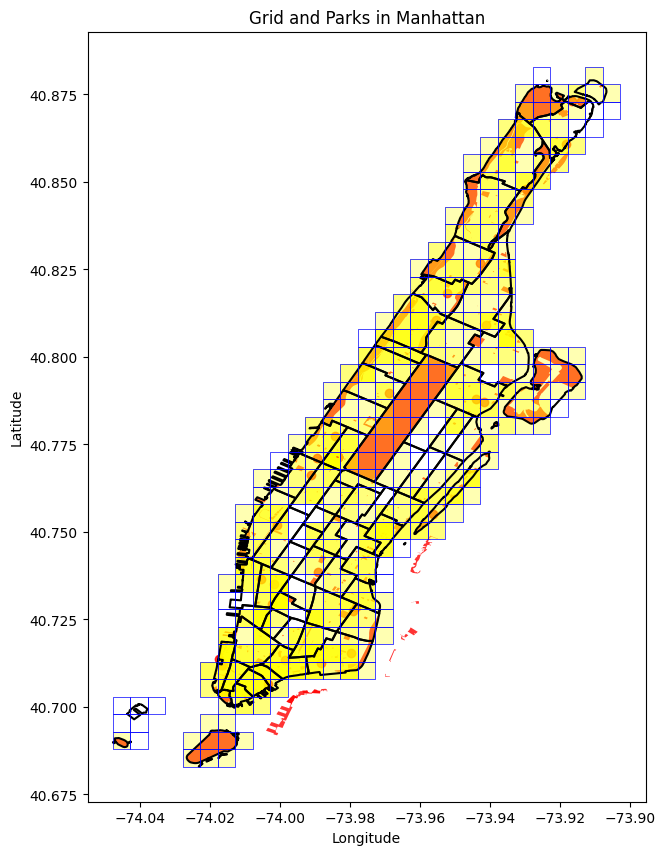

In [8]:
import matplotlib.pyplot as plt

# Plot the grid and parks
fig, ax = plt.subplots(figsize=(10, 10))
manhattan_taxi_zones_gdf.boundary.plot(ax=ax, color='black')
grid.boundary.plot(ax=ax, color='blue', linewidth=0.5)
manhattan_parks_gdf.plot(ax=ax, color='red', alpha=0.8)
grid_with_parks[grid_with_parks['contains_park']].plot(ax=ax, color='yellow', alpha=0.3)  # Highlight cells that contain parks

plt.title('Grid and Parks in Manhattan')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



In [9]:
grid_with_parks['contains_park'].value_counts()

contains_park
True     768
False     33
Name: count, dtype: int64

### Finding matching parks with taxi zones

In [10]:
busyness_taxizones= gpd.read_file("C:/Users/Justh/OneDrive/Documents/MScComputerScience/S3 Research Practicum/DataAnalysis/preprocessing/yellow_taxi/passengers_by_zone_datetime.geojson")

In [11]:
type(manhattan_parks_gdf)

geopandas.geodataframe.GeoDataFrame

In [12]:
manhattan_parks_gdf.columns

Index(['id', 'name', 'website', 'area', 'geometry'], dtype='object')

In [13]:
print(manhattan_parks_gdf.geometry.name)

geometry


In [14]:
busyness_taxizones.shape[0]

115879

In [15]:
busyness_taxizones.columns

Index(['location_id', 'year', 'month', 'day', 'hour', 'passenger_count_number',
       'zone', 'geometry'],
      dtype='object')

In [16]:
# Perform a spatial join to find parks within each taxi zone
parks_with_zones = gpd.sjoin(manhattan_parks_gdf, busyness_taxizones, how='inner', predicate='intersects')

#rename for clarity
parks_with_zones = parks_with_zones.rename(columns={'id':'park_id','location_id': 'taxi_zone_id', 'name': 'park_name','zone':'taxi_zone'})

print(parks_with_zones[['park_name', 'taxi_zone_id']])


         park_name taxi_zone_id
0    John Jay Park          140
0    John Jay Park          140
0    John Jay Park          140
0    John Jay Park          140
0    John Jay Park          140
..             ...          ...
471           None          142
471           None          142
471           None          142
471           None          142
471           None          142

[895969 rows x 2 columns]


In [17]:
parks_with_zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 895969 entries, 0 to 471
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   park_id                 895969 non-null  object  
 1   park_name               711578 non-null  object  
 2   website                 303386 non-null  object  
 3   area                    895969 non-null  float64 
 4   geometry                895969 non-null  geometry
 5   index_right             895969 non-null  int64   
 6   taxi_zone_id            895969 non-null  object  
 7   year                    895969 non-null  object  
 8   month                   895969 non-null  object  
 9   day                     895969 non-null  object  
 10  hour                    895969 non-null  object  
 11  passenger_count_number  895969 non-null  int64   
 12  taxi_zone               895969 non-null  object  
dtypes: float64(1), geometry(1), int64(2), object(9)
memory usag

In [50]:
parks_with_zones.head(30)

,park_id,park_name,website,area,geometry,index_right,taxi_zone_id,year,month,day,hour,passenger_count_number,taxi_zone
0,relation/1751075,John Jay Park,None,0.000001,"POLYGON ((-73.94901 40.76981, -73.94944 40.770...",17495,140,2022,4,6,12,18,Lenox Hill East
0,relation/1751075,John Jay Park,None,0.000001,"POLYGON ((-73.94901 40.76981, -73.94944 40.770...",17496,140,2022,4,6,13,5,Lenox Hill East
0,relation/1751075,John Jay Park,None,0.000001,"POLYGON ((-73.94901 40.76981, -73.94944 40.770...",17497,140,2022,4,6,17,22,Lenox Hill East
0,relation/1751075,John Jay Park,None,0.000001,"POLYGON ((-73.94901 40.76981, -73.94944 40.770...",17498,140,2022,4,6,18,65,Lenox Hill East
0,relation/1751075,John Jay Park,None,0.000001,"POLYGON ((-73.94901 40.76981, -73.94944 40.770...",17499,140,2022,4,6,19,10,Lenox Hill East
0,relation/1751075,John Jay Park,None,0.000001,"POLYGON ((-73.94901 40.76981, -73.94944 40.770...",17500,140,2022,4,6,8,32,Lenox Hill East
0,relation/1751075,John Jay Park,None,0.000001,"POLYGON ((-73.94901 40.76981, -73.94944 40.770...",17501,140,2022,4,6,9,28,Lenox Hill East
0,relation/1751075,John Jay Park,None,0.000001,"POLYGON ((-73.94901 40.76981, -73.94944 40.770...",17502,140,2022,4,7,10,7,Lenox Hill East
0,relation/1751075,John Jay Park,None,0.000001,"POLYGON ((-73.94901 40.76981, -73.94944 40.770...",17503,140,2022,4,7,13,21,Lenox Hill East
0,relation/1751075,John Jay Park,None,0.000001,"POLYGON ((-73.94901 40.76981, -73.94944 40.770...",17504,140,2022,4,7,14,5,Lenox Hill East


In [58]:
parks_taxi_info_datetime_hourly= parks_with_zones

In [54]:
type(parks_with_zones)

geopandas.geodataframe.GeoDataFrame

In [60]:
parks_taxi_info_datetime_hourly.to_file('parks_taxi_info_datetime_hourly.geojson',driver='GeoJSON')

In [20]:
park_passenger_numbers= parks_with_zones['passenger_count_number'].value_counts()
park_passenger_numbers.to_csv('passenger_counts_distribution.csv')


In [21]:
park_passenger_numbers= parks_with_zones['passenger_count_number'].value_counts()
park_passenger_numbers

passenger_count_number
1      133672
2       98542
3       76322
4       64746
5       54833
        ...  
218         1
139         1
128         1
223         1
145         1
Name: count, Length: 166, dtype: int64

In [22]:
parks_with_zones.shape

(895969, 13)

In [34]:
park_busyness_details= parks_with_zones[['park_id','park_name','taxi_zone_id','geometry']]

In [35]:
park_busyness_details.head()

,park_id,park_name,taxi_zone_id,geometry
0,relation/1751075,John Jay Park,140,"POLYGON ((-73.94901 40.76981, -73.94944 40.770..."
0,relation/1751075,John Jay Park,140,"POLYGON ((-73.94901 40.76981, -73.94944 40.770..."
0,relation/1751075,John Jay Park,140,"POLYGON ((-73.94901 40.76981, -73.94944 40.770..."
0,relation/1751075,John Jay Park,140,"POLYGON ((-73.94901 40.76981, -73.94944 40.770..."
0,relation/1751075,John Jay Park,140,"POLYGON ((-73.94901 40.76981, -73.94944 40.770..."


In [36]:
park_busyness_details.shape

(895969, 4)

In [41]:
park_busyness_details= parks_with_zones.groupby(['park_id','park_name','taxi_zone_id','geometry'])['passenger_count_number'].sum().reset_index(name='busyness')


In [42]:
park_busyness_details

,park_id,park_name,taxi_zone_id,geometry,busyness
0,node/11457630561,Kowsky Plaza,13,POINT (-74.01693 40.71186),12778
1,node/1203709404,Sherman Creek,127,POINT (-73.91834 40.86097),1159
2,node/357545993,Baker Field,128,POINT (-73.91403 40.87316),90
3,node/357607904,South Street Seaport Historic District,209,POINT (-74.00337 40.70651),4284
4,node/357608159,Pumphouse Park,13,POINT (-74.01617 40.71207),12778
...,...,...,...,...,...
395,way/964822654,Seward Park Extension Park,232,"POLYGON ((-73.98498 40.71705, -73.98517 40.716...",7243
396,way/973521995,Ahearn Park,232,"POLYGON ((-73.98368 40.71489, -73.98367 40.714...",7243
397,way/985281628,Seward Park High School - Community Playground,232,"POLYGON ((-73.98959 40.71557, -73.98896 40.715...",7243
398,way/990936691,Pier 42 Upland Park,232,"POLYGON ((-73.98118 40.71072, -73.98157 40.710...",7243


In [ ]:
park_busyness_by_park_description= parks_with_zones.groupby(['park_id','park_name'])['passenger_count_number'].sum().reset_index()


In [ ]:
park_busyness_by_park_description.shape

(364, 3)

In [ ]:
park_busyness_by_park_description.head(20)

,park_id,park_name,passenger_count_number
0,node/11457630561,Kowsky Plaza,12778
1,node/1203709404,Sherman Creek,1159
2,node/357545993,Baker Field,90
3,node/357607904,South Street Seaport Historic District,4284
4,node/357608159,Pumphouse Park,12778
5,node/357610563,Chatham Square,4218
6,node/357616290,Seventieth Street Playground,23082
7,node/357616388,Lawrence A Wein Stadium,90
8,node/357620387,Theodore Roosevelt Birthplace National Histori...,35762
9,node/357624604,McNally Plaza,78


In [43]:
park_busyness_details.head()

,park_id,park_name,taxi_zone_id,geometry,busyness
0,node/11457630561,Kowsky Plaza,13,POINT (-74.01693 40.71186),12778
1,node/1203709404,Sherman Creek,127,POINT (-73.91834 40.86097),1159
2,node/357545993,Baker Field,128,POINT (-73.91403 40.87316),90
3,node/357607904,South Street Seaport Historic District,209,POINT (-74.00337 40.70651),4284
4,node/357608159,Pumphouse Park,13,POINT (-74.01617 40.71207),12778


In [44]:
# Set the geometry column explicitly
park_busyness_details = gpd.GeoDataFrame(park_busyness_details, geometry='geometry')

In [48]:
park_busyness_details.to_file('park_busyness_details.geojson',driver='GeoJSON')


In [49]:
park_busyness_details.to_csv('park_busyness_details.csv')

In [45]:
park_busyness_details.explore("busyness", legend=True)

#### Within (testing)

In [47]:
type(park_busyness_details)

geopandas.geodataframe.GeoDataFrame

In [ ]:
# Perform a spatial join to find parks within each taxi zone
parks_with_zones_within = gpd.sjoin(manhattan_parks_gdf, busyness_taxizones, how='inner', predicate='within')

# Rename columns for clarity
parks_with_zones_within = parks_with_zones_within.rename(columns={'id':'park_id','location_id': 'taxi_zone_id', 'name': 'park_name','zone':'taxi_zone'})

# Display the resulting DataFrame
print(parks_with_zones_within[['park_name', 'taxi_zone_id']])


         park_name taxi_zone_id
0    John Jay Park          140
0    John Jay Park          140
0    John Jay Park          140
0    John Jay Park          140
0    John Jay Park          140
..             ...          ...
471           None          142
471           None          142
471           None          142
471           None          142
471           None          142

[743206 rows x 2 columns]


In [ ]:
park_busyness_total_geometry_within= parks_with_zones_within.groupby(['park_id','park_name','taxi_zone_id','geometry'])['passenger_count_number'].sum().reset_index()


In [ ]:
park_busyness_total_geometry_within.rename(columns = {'passenger_count_number':'busyness'}, inplace = True)

In [ ]:
# Set the geometry column explicitly
park_busyness_total_geometry_within = gpd.GeoDataFrame(park_busyness_total_geometry_within, geometry='geometry')

In [ ]:
park_busyness_total_geometry_within.explore("busyness", legend=True)